# Very Simple Neural Network

This network can be used to demonstrate how to implement the backprop algorithm.
This notebook represents the code associated with the writeup on [my blog](https://sharkovsky.github.io/2017/06/07/naive-backprop.html).

The structure of the network is very simple, although slightly more general than the one described in [the blogpost](https://sharkovsky.github.io/2017/06/07/naive-backprop.html).

The network has:
1. an input layer
2. an arbitrary number of fully connected sigmoid layers
3. an output layer.

The prupose of the network is to perform **classification**.

In [1]:
import numpy as np
import sys
print(sys.version_info)
print(np.__version__)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
1.12.1


## General structure

I am going to define a the network at the layer-level.
This means that there will be a python class for each layer.

Each layer must contain at least:
1. knowledge of how many neurons it has (`N`);
2. knowledge of how many neurons were in the previous layer (`Nprev`);
2. a vector of hidden states of size `N` (`h`);
2. a matrix `W` of weights, of size `N`-by-`Nprev`;
2. a vector `b` of biases, of size `N`;
3. a forward method that takes a vector of size `Nprev` as input, and the returns the vector of activations of size `N`;
3. a backward method that computes the error signal.

### Input layer

The input layer takes a vector of size `n`, and simply outputs the exact same vector.
As of right now, this is not the most useful of layers.
But in principle one could benefit from this infrastructure to implement some pre-processing (e.g. creating new features).

In [2]:
class InputLayer():
    def __init__(self, n=2):
        self.N = n
        self.Nprev = n
        self.h = np.zeros(shape=(self.N,1))
        
    def forward(self, x):
        x = np.array([x])
        x = x.reshape(self.Nprev,1)
        self.h = x
        return self.h
    
    def backward(self):
        pass

### Sigmoid Layer

all the *hidden* layers of this network are going to be of this type.
The activation function is the sigmoid, defined by

$ \sigma(z) = \frac{1}{1 + e^{-z}} $

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

#### forward pass:

Since we are using the formulation that includes both weights and biases, this is how the forward activation of the layer will be computed:

$ \mathbf{z}_l = W_l \mathbf{h}_{l-1} + b_l $

$ \mathbf{h}_l = \mathbf{\sigma} ( \mathbf{z}_l ) $ 

#### backward pass:

As a reminder, the backprop algorithm was explained as:

1. compute the gradient of the cost function, evaluated on the activations of the last layer;
2. set the *error signal*
$$ \mathbf{ \delta } = \nabla C \Bigg|_{\mathbf{y}} $$
3. for each layer $ l $ going backwards:
  - update the weight matrix
$$ W_l \leftarrow W_l - \eta \left ( \mathbf { \delta } \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) \otimes \mathbf{h}_{l-1}$$
  - backpropagate the error signal
$$ \mathbf { \delta } = W_l^T \left ( \mathbf { \delta } \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $$.

There is a relatively simple addition, which is the update of the biases:

$ \mathbf{b}_l \leftarrow \mathbf{b}_l - \eta \delta $


The `backward` method of the layer has two responsibilities:
- compute the update factor 
$ \left ( \mathbf { \delta } \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $
- compute the error signal to be backpropagated
$ W_l^T \left ( \mathbf { \delta } \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $

Remember, the update factor for layer $l$ has size $N_l$, whereas the error signal has size $N_{l-1}$.

###### important note

Troughout this notebook I am going to use the fact that

$ \frac{d\sigma}{dz} \Big|_{z_0} = \sigma(z_0)( 1 - \sigma(z_0) ) $

In [4]:
class SigmoidLayer():
    def __init__(self, n=5, nprev=5):
        self.N = n
        self.Nprev = nprev
        
        self.h = np.zeros(shape=(self.N,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(self.N,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(self.N,self.Nprev))
        self.Wupdates = np.zeros_like(self.W)
        
    def forward(self, x):
        x = np.array([x])
        x = x.reshape(self.Nprev,1)
        z = (self.W @ x).reshape(self.N,1) + self.b
        self.h = sigmoid(z)
        return self.h
    
    def backward(self, delta):
        update_fac = delta * self.h * ( 1. - self.h )
        new_delta = self.W.T @ update_fac

        return update_fac, new_delta
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)

### Output layer

is a bit more complicated than the input layer.
First of all, the output layer has knowledge of the cost function. 
Additionally, the `backward` method takes the *true label* as input.

### Cost function

We are going to use [cross-entropy](https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks) for binary data, the most famous cost function for classification.

For a single datapoint, if we define $y$ as the true label (which can take values 0 or 1) and $p$ as the predicted probability for that class by our model, we have the cross-entropy as

$ - y \log ( p ) - ( 1 - y ) \log (1 - p) $

In [5]:
class CrossEntropy():
        
    def error(self, y,a):
        return -y*np.log(a) - (1.-y)*np.log(1. - a)
    
    def derror(self,a, y):
        return a - y

In [6]:
CostFunction = CrossEntropy()

In [7]:
class SigmoidOutputLayer():
    def __init__(self, n=1, nprev=5, cost=CrossEntropy() ):
        self.N = n
        self.Nprev = nprev
        
        self.h = np.zeros(shape=(self.N,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(self.N,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(self.N,self.Nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.cost_ = cost
        
    def forward(self, x):
        x = np.array([x])
        x = x.reshape(self.Nprev,1)        
        
        z = (self.W @ x) + self.b
        self.h = sigmoid(z)
        return self.h
    
    def backward(self, y):
        update_fac = self.cost_.derror(self.h,y)*self.h*(1. - self.h)
        new_delta = self.W.T @ update_fac

        return update_fac, new_delta
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)        

## Generate some fake classification data

In [8]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
% matplotlib inline

In [9]:
n_input = 2

X, y = make_classification(n_samples=800, n_features=n_input, 
                           n_informative=n_input, n_redundant=0,
                           n_classes=2, n_clusters_per_class=1, 
                           random_state=42023)

In [10]:
n_input = 2
X, y = make_moons( n_samples=800, noise=0.2 )

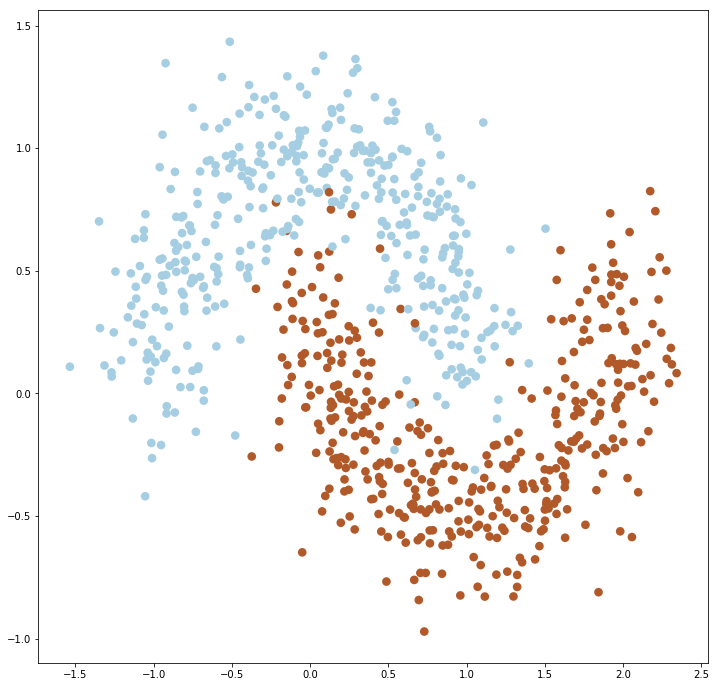

In [11]:
plt.figure(figsize=(12,12))
plt.scatter(X[:,0],X[:,1],c=y, s=75, linewidths=0, cmap=plt.cm.Paired)

## Instantiate a network

In [12]:
n_hidden_neurons = [8,5]
n_hidden_layers = len(n_hidden_neurons)
nlayers = n_hidden_layers+2

In [13]:
layers = []
layers.append( InputLayer(n_input) )
nprev = n_input
for n in n_hidden_neurons:
    layers.append(SigmoidLayer(n, nprev))
    nprev = n
layers.append(SigmoidOutputLayer(1,nprev,CostFunction))

## Train and validate

A common practice is to split the dataset in training and validation.
This is done to try to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting).


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42 )

In [15]:
eta = 5.0
n_epochs = 50

training_error = []
validation_error = []
    
for i in range(n_epochs):

    errors = []
    for idx, data_sample in enumerate(X_train):
        # feedforward
        a = layers[0].forward(data_sample)
        for i in range(1,nlayers):
            a = layers[i].forward(a)

        errors.append(CostFunction.error(y_train[idx], a))
    
        # backprop last layer
        update_fac, delta = layers[-1].backward(y_train[idx])
        layers[-1].Wupdates = eta*np.outer(update_fac, layers[nlayers-2].h )
        layers[-1].bupdates = eta*update_fac
        
        # backprop previous layers
        for i in range(nlayers-2,0,-1):
            update_fac, delta = layers[i].backward(delta)
            layers[i].Wupdates = eta*np.outer(update_fac , layers[i-1].h)
            layers[i].bupdates = eta*update_fac
            
        # apply updates
        for i in range(1,nlayers):
            layers[i].update()
            
    training_error.append(np.mean(errors))
    
    # validation
    errors = []
    for idx, data_sample in enumerate(X_test):
        # feedforward
        a = layers[0].forward(data_sample)
        for i in range(1,nlayers):
            a = layers[i].forward(a)
        errors.append(CostFunction.error(y_test[idx], a[0]))
    validation_error.append(np.mean(errors))

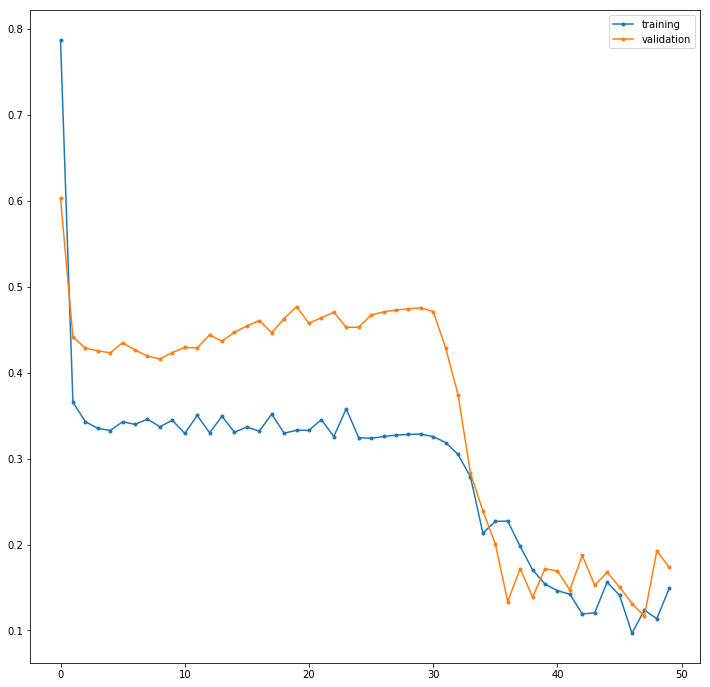

In [16]:
plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), training_error, '.-')
plt.plot(range(n_epochs), validation_error, '.-')
plt.legend(['training','validation'])

## Inference time

Let's do some inference!
This means trying to predict the class of new data points.

We can even do something cooler and plot a *decision surface* that shows how very point of the plane would be classed.

In [17]:
def inference(layers, x):
    a = x
    for i in range(nlayers):
        a = layers[i].forward(a)
        
    return a > 0.5

In [18]:
print(inference(layers, np.array([3.5, -3.0]).reshape(2,1)))
print(inference(layers, np.array([-2.0, 2.0]).reshape(2,1)))

[[ True]]
[[False]]


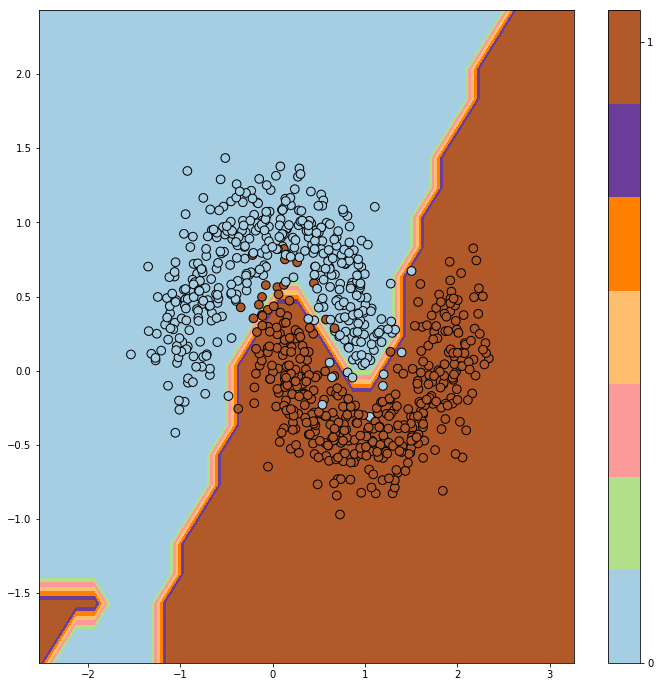

In [19]:
h=0.2
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = np.zeros_like(xx)

# here "model" is your model's prediction (classification) function
for ix, x in enumerate(xx[0,:]):
    for iy, yv in enumerate(yy[:,0]):
        Z[iy,ix] = inference(layers, np.r_[x, yv])[0]

# Put the result into a color plot
#Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,12))
plt.contourf(xx, yy, Z, LevelStep=1, cmap=plt.cm.Paired)
plt.colorbar(ticks=[-1,0,1])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=75, linewidth=1,  edgecolor='black')